## Assignment 3, 2022201027
### NLP Q1

_Bert tweet model for regressing the sentiment scores of tweets_

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 29.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from matplotlib import style
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from transformers import AutoTokenizer, AutoModel, AutoConfig, BertPreTrainedModel
import torch

In [4]:
# load data
tweets = pd.read_csv("data/q1/train.csv", index_col=0)
tweets

,text,score
0,How the fu*k! Who the heck! moved my fridge!.....,0.938
1,So my Indian Uber driver just called someone t...,0.896
2,@DPD_UK I asked for my parcel to be delivered ...,0.896
3,so ef whichever butt wipe pulled the fire alar...,0.896
4,Don't join @BTCare they put the phone down on ...,0.896
...,...,...
5750,Why does Candice constantly pout #GBBO 💄😒,0.396
5751,"@redBus_in #unhappy with #redbus CC, when I ta...",0.604
5752,"@AceOperative789 no pull him afew weeks ago, s...",0.479
5753,I'm buying art supplies and I'm debating how s...,0.375


In [ ]:
!pip3 install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=3130234afe0c0e76cfa3cfadaedfb69e0effe1eee4d1dbcab4810905cc53d211
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [13]:
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', normalization=True) # or 'roberta-base'
tweets['text'][0], torch.tensor([tokenizer.encode(tweets['text'][0])])

('How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##',
 tensor([[    0,   203,     6, 11644,   110,   536,    12,   449,     6,  6048,
             12,  1985,    23,  7489,    12,    28,   151,     8,  4251,     6,
          30598,  1279,     4,    85,  2486,    85,   623,   465,   465,     2]]))

In [41]:
#Tokenize the whole train set
train_encodings = tokenizer(list(tweets['text'].values), padding=True, truncation=True, return_tensors="pt")
train_encodings.__dict__

{'data': {'input_ids': tensor([[   0,  203,    6,  ...,    1,    1,    1],
          [   0,  180,   23,  ...,    1,    1,    1],
          [   0,    5,    8,  ...,    1,    1,    1],
          ...,
          [   0,    5,   80,  ...,    1,    1,    1],
          [   0,    8,   40,  ...,    1,    1,    1],
          [   0,    5, 1373,  ...,    1,    1,    1]]),
  'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]),
  'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]])},
 '_encodings': None,
 '_n_sequences': None}

In [45]:
train_encodings.data['input_ids'].size()

torch.Size([5755, 56])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# def tokenize_text(text):
#     return tokenizer(text, add_special_tokens=True)
# train_tokens = tweets["text"].apply(tokenize_text)
# train_tensors = [torch.tensor(token) for token in train_tokens]

# max_size = max([t.size(0) for t in train_tensors])

# # Pad the shorter tensors with zeros
# padded_tensors = [torch.cat([t, torch.zeros(max_size - t.size(0))]) for t in train_tensors]

# train_encodings = tokenizer(list(tweets['text'].values), padding=True, truncation=True, return_tensors="pt")

batch_size = 16
train_loader = DataLoader(TensorDataset(train_encodings.data['input_ids'], train_encodings.data['attention_mask'],
                                train_encodings.data['token_type_ids'], torch.tensor(tweets["score"].values)), 
                                batch_size=batch_size, shuffle=True)

In [ ]:
from torch import nn
class BertRegresser(nn.Module):
    def __init__(self, model_name):
        super(BertRegresser, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        # print(self.bert.config.hidden_size)
        self.fcn = nn.Linear(self.bert.config.hidden_size, 256)
        self.ff1 = nn.Linear(256,128)
        self.tanh = nn.Tanh()
        self.ff2 = nn.Linear(128,1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        #Feed the input to Bert model to obtain contextualized representations
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        #Obtain the representations of [CLS] heads
        logits = outputs.last_hidden_state[:,0,:]
        output = torch.relu(self.fcn(logits))
        # output = self.relu1(output)
        output = self.ff1(output)
        output = self.tanh(output)
        out = self.ff2(output)
        return out

In [ ]:
import torch.optim as optim

# config = AutoConfig.from_pretrained('vinai/bertweet-base')
# config.num_labels = 1
# config.problem_type = "regression"
model = BertRegresser('vinai/bertweet-base')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
num_epochs = 5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, last_epoch=-1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda', index=0)

In [ ]:
model

BertRegresser(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Train
for epoch in range(num_epochs):
    # Train
    model.train()
    total_loss = 0.
    for input_ids, attention_masks, token_type_ids, labels in tqdm(train_loader):
        optimizer.zero_grad()
        # print(labels.size(), input_ids.size())
        input_ids, attention_masks, labels, token_type_ids = input_ids.to(device), attention_masks.to(device), labels.to(device), token_type_ids.to(device)
        output = model(input_ids, attention_masks, token_type_ids)
        loss = criterion(output.squeeze(1).float(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()
    if scheduler:
        scheduler.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0421


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0387


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0383


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0373


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0374


In [ ]:
torch.save(model.state_dict(), './bertweet.pth')

In [ ]:
test_tweets = pd.read_csv("test.csv", index_col=0)

test_encodings = tokenizer(list(test_tweets['text'].values), padding=True, truncation=True, return_tensors="pt")
test_loader = DataLoader(TensorDataset(test_encodings.data['input_ids'], test_encodings.data['attention_mask'],
                                test_encodings.data['token_type_ids'], torch.tensor(test_tweets["score"].values)), 
                                batch_size=1, shuffle=True)

# test_loader = DataLoader(TensorDataset(torch.stack(padded_tensors), torch.tensor(test_tweets["score"].values)), 
#                                 batch_size=1, shuffle=True)

In [ ]:
# Evaluate on test set
import math

model.eval()
with torch.no_grad():
    total_loss = 0
    # total_samples = 0
    for input_ids, attention_masks, token_type_ids, labels in tqdm(test_loader):
        input_ids, attention_masks, labels, token_type_ids = input_ids.to(device), attention_masks.to(device), labels.to(device), token_type_ids.to(device)
        output = model(input_ids, attention_masks, token_type_ids)
        loss = criterion(output.squeeze(1).float(), labels.float())
        total_loss += loss.cpu().item()
        # total_samples += len(labels)
    test_loss = total_loss / len(test_loader)
    rmse = math.sqrt(test_loss)
    print(f"Test RMSE: {rmse:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Test RMSE: 0.2010


### Q2

In [ ]:
# labels = ["arts and culture", "business and entrepreneurs", "pop culture", "daily life", "sports and gaming", "science and technology"]
from transformers import pipeline
from sklearn.metrics import classification_report as clr

device = 0 if torch.cuda.is_available() else -1
print("Using device:", device)

classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      device=device)



Using device: 0


In [ ]:
tweets = pd.read_csv("data/q2/tweet_topics.csv", index_col=0)

tweets


,text,date,label,label_name,id
0,The {@Clinton LumberKings@} beat the {@Cedar R...,2019-09-08,4,sports_&_gaming,1170516324419866624
1,Major sidenote of the MSU game: How about the ...,2019-09-08,4,sports_&_gaming,1170516407135522816
2,I would rather hear Eli Gold announce this Aub...,2019-09-08,4,sports_&_gaming,1170516440690176006
3,"Someone take my phone away, I’m trying to not ...",2019-09-08,4,sports_&_gaming,1170516543387709440
4,"A year ago, Louisville struggled to beat an FC...",2019-09-08,4,sports_&_gaming,1170516620466429953
...,...,...,...,...,...
3593,#NowPlaying Leaving in the Morning - Chicken D...,2020-08-30,2,pop_culture,1300161140828368897
3594,A little bit of humour for #politas this morni...,2020-08-30,3,daily_life,1300190823863083008
3595,TheRealDimmak is live on YouTube (Call of Duty...,2020-08-30,4,sports_&_gaming,1300220478716547072
3596,. {{USERNAME}} : RPT #Sinopec posts first hal...,2020-08-30,1,business_&_entrepreneurs,1300221757824139264


In [ ]:
labels = tweets.label.unique()
tweets.label_name.unique()

array(['sports_&_gaming', 'pop_culture', 'arts_&_culture', 'daily_life',
       'business_&_entrepreneurs', 'science_&_technology'], dtype=object)

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# tweets = tweets.drop_duplicates(subset=['text']) # Remove duplicate tweets
tweets['text'] = tweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tweets

,text,date,label,label_name,id
0,{@Clinton LumberKings@} beat {@Cedar Rapids Ke...,2019-09-08,4,sports_&_gaming,1170516324419866624
1,Major sidenote MSU game: media team making cus...,2019-09-08,4,sports_&_gaming,1170516407135522816
2,would rather hear Eli Gold announce Auburn gam...,2019-09-08,4,sports_&_gaming,1170516440690176006
3,"Someone take phone away, I’m trying look {@Chi...",2019-09-08,4,sports_&_gaming,1170516543387709440
4,"year ago, Louisville struggled beat FCS oppone...",2019-09-08,4,sports_&_gaming,1170516620466429953
...,...,...,...,...,...
3593,#NowPlaying Leaving Morning - Chicken Diamond ...,2020-08-30,2,pop_culture,1300161140828368897
3594,little bit humour #politas morning. Waratah ci...,2020-08-30,3,daily_life,1300190823863083008
3595,TheRealDimmak live YouTube (Call Duty Black Op...,2020-08-30,4,sports_&_gaming,1300220478716547072
3596,. {{USERNAME}} : RPT #Sinopec posts first half...,2020-08-30,1,business_&_entrepreneurs,1300221757824139264


Both raw and preprocessed tweets gave same zero-shot **accuracy**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

batch_size = 32

y_true = tweets.label_name
y_pred = []

# for index,tweet in tqdm(tweets.iterrows()):
#     # print(tweet['text'])
#     result = classifier(tweet, labels)
#     # print(labels[np.argmax(result['scores'])])
#     y_pred.append(labels[np.argmax(result['scores'])])

for i in tqdm(range(0, len(tweets), batch_size)):
    batch = tweets.iloc[i:i+batch_size]
    batch_results = classifier(batch.text.tolist(), labels)
    batch_y_pred = [labels[np.argmax(result['scores'])] for result in batch_results]
    y_pred.extend(batch_y_pred)


  0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
print(clr(y_true.values, np.array(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.00      0.00      0.00       151
           2       0.00      0.00      0.00      1378
           3       0.00      0.00      0.00       605
           4       0.34      1.00      0.51      1217
           5       0.00      0.00      0.00       190

    accuracy                           0.34      3598
   macro avg       0.06      0.17      0.08      3598
weighted avg       0.11      0.34      0.17      3598



We observe that the zero-shot pipeline gives poor accuracy for classes other than sports and technology

### Q3 Biases in bert-base-uncased

In case of caste axis of disparity, we hardly observe any consistent bias in the BERT base model so we switched to the DistilBERT wherein we clearly see demarcations in the top 5 mask substitutions. The other 2 axes show bias in BERT base-uncased itself.

We can note that the caste setting is not so much prevalent in the training data fed to this model which is primarily dominant with western discourse, whereas gender biases appears more commonly as historical stereotypes and religious biases more commonly as more recent controversial news texts which has influenced the following predictions.

We collect the predictions from the inference API of hugging face and present the results below.

![caste](caste_bias.png)

![religion](religion_bias.png)

![gender](gender_bias.png)

### Causal Q4

_Propensity score v/s classification model_

<p> A propensity score model differs from a standard classification model in that it aims to ensure the distribution over all the potential confounder variables is same or similar for samples belonging to the treatment group as well as the control group. Thus it indirectly reports the probability that a sample with a set of features will exhibit a certain behaviour or preference towards treatment.
</p>
<p>Unlike a classification task, it doesn't aim to make a decision boundary for separability, but rather check that the probability of getting treated for the similarly behaving samples be similarly distributed across all the samples. This is verified by plotting the distribution of treatment and control samples against the propensity scores extracted by fitting the data on the intervention events occured or not(ground truths), and checking that it largely overlaps for both groups.</p>
<p>The outcome variable of a propensity model is binary and the independent variables are usually related to demographics or transactions (at least in the first stage) wherease for a classification model, the outcome variables are categorical and the independent variables could be a set of singular or compositional features.</p>

### Q5

In [12]:
data = pd.read_csv("data/titanic/train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
type(data['Cabin'][1])==float

False

In [13]:
from sklearn.impute import KNNImputer

def transform_port(x):
    if x=='S':
        return 1
    elif x=='C':
        return 2
    else:
        return 3

data['Cabin'] = data['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
data['Sex'] = data['Sex'].fillna(1).apply(lambda x: 1 if x=='male' else 0)
# data['Embarked'] = data['Embarked'].apply(lambda x: transform_port(x))
imputer = KNNImputer(n_neighbors=3)


T = 'Cabin'
Y = 'Survived'
X = data.columns.drop(['PassengerId','Name','Ticket','Embarked', T, Y])
target = data[T]
data = pd.DataFrame(imputer.fit_transform(data[X]), columns=X)
data


,Pclass,Sex,Age,SibSp,Parch,Fare
0,3.0,1.0,22.000000,1.0,0.0,7.2500
1,1.0,0.0,38.000000,1.0,0.0,71.2833
2,3.0,0.0,26.000000,0.0,0.0,7.9250
3,1.0,0.0,35.000000,1.0,0.0,53.1000
4,3.0,1.0,35.000000,0.0,0.0,8.0500
...,...,...,...,...,...,...
886,2.0,1.0,27.000000,0.0,0.0,13.0000
887,1.0,0.0,19.000000,0.0,0.0,30.0000
888,3.0,0.0,14.666667,1.0,2.0,23.4500
889,1.0,1.0,26.000000,0.0,0.0,30.0000


In [14]:
ps_model = LogisticRegression(C=1e6).fit(data, target)

In [19]:
data_ps = data.assign(propensity_score=ps_model.predict_proba(data)[:, 1])
# data_ps

In [18]:
data_ps['cabin'] = target
data_ps

,Pclass,Sex,Age,SibSp,Parch,Fare,propensity_score,cabin
0,3.0,1.0,22.000000,1.0,0.0,7.2500,0.006809,0
1,1.0,0.0,38.000000,1.0,0.0,71.2833,0.805332,1
2,3.0,0.0,26.000000,0.0,0.0,7.9250,0.010940,0
3,1.0,0.0,35.000000,1.0,0.0,53.1000,0.806255,1
4,3.0,1.0,35.000000,0.0,0.0,8.0500,0.006575,0
...,...,...,...,...,...,...,...,...
886,2.0,1.0,27.000000,0.0,0.0,13.0000,0.123583,0
887,1.0,0.0,19.000000,0.0,0.0,30.0000,0.826855,1
888,3.0,0.0,14.666667,1.0,2.0,23.4500,0.022287,0
889,1.0,1.0,26.000000,0.0,0.0,30.0000,0.743272,1


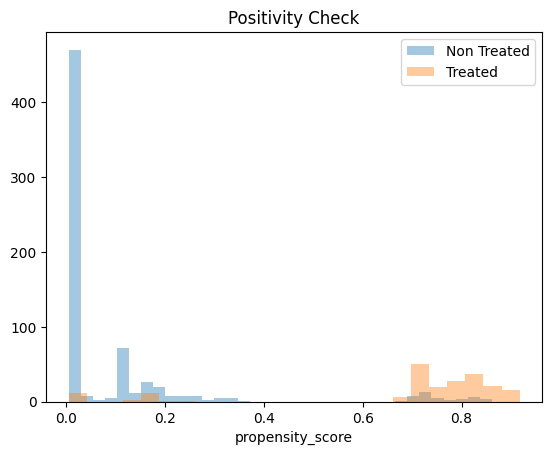

In [20]:
sns.distplot(data_ps.query("cabin==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("cabin==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend()

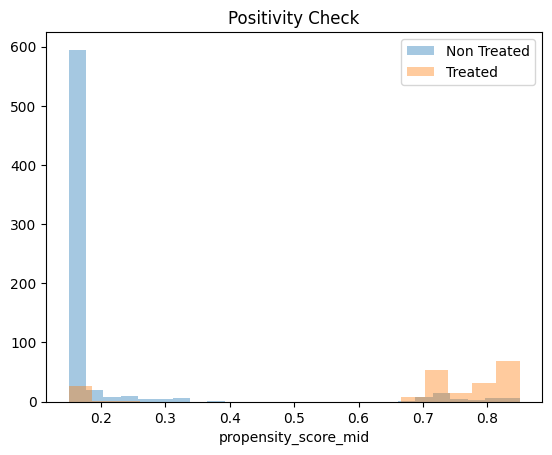

In [11]:
# Remove outliers
data_ps["propensity_score_mid"] = np.clip(data_ps["propensity_score"], 0.15, 0.85)

# Plot barplot
sns.distplot(data_ps.query("cabin==0")["propensity_score_mid"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("cabin==1")["propensity_score_mid"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend()


In [21]:
ps = data_ps['propensity_score'].values
logit_p = np.log(ps/(1-ps))
caliper = 0.25 * np.std(logit_p)

caliper

0.6398068640361284

From the caliper, it seems clear that there is a confounder variable in the sex of the passenger

In [22]:
control_ids = data_ps[data_ps['cabin']==0].index
treatment_ids = data_ps[data_ps['cabin']==1].index

matched_pairs = {}
for tid in tqdm(treatment_ids):
    matched_pairs[tid] = []
    for cid in control_ids:
        matched_pairs[tid].append((abs(data_ps['propensity_score'].iloc[tid] - data_ps['propensity_score'].iloc[cid]),cid))

for tid in tqdm(treatment_ids):
    matched_pairs[tid] = [i for i in matched_pairs[tid] if i[0]<caliper]

matched_pairs_final = {}
for k,v in matched_pairs.items():
    matched_pairs_final[k] = min(v)

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [23]:
SMD = {col:{'t_values':[],'c_values':[],'SMD':None} for col in X}

for k,v in matched_pairs_final.items():
    for col in X:
        SMD[col]['t_values'].append(data_ps[col].iloc[k])
        SMD[col]['c_values'].append(data_ps[col].iloc[v[1]])

for k,v in SMD.items():
    num = np.mean(v['t_values'])-np.mean(v['c_values'])
    dom = ((np.std(v['t_values'])**2) + (np.std(v['c_values'])**2))/2
    v['SMD'] = num/np.sqrt(dom)
    print(k, v['SMD'])